# Speed control in biological sequence-generating network

Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.


## Next steps

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=2e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, E_A=-0.1, T_E=.002, T_I=.002, T_A=0.01,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    N_P_I = 30, # num nrns in inhibitory pool
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E_I=0.1e-3,  # I->E input weights
    W_A=.05e-3, # adaptation weight for all neurons
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

def set_dynamic_vars(m):
    m.N_E = m.N_L * m.N_L_E
    m.N_N = m.N_E + m.N_P_I

set_dynamic_vars(M)

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


# Full chain

### Helper functions for analyzing behavior of chain during simulation

In [2]:
def spk_tms_for_link(spks_t, spks_c, idx, n_l_e):
    link_start_idx = idx * n_l_e
    window = (spks_c >= link_start_idx) & (spks_c < (link_start_idx + n_l_e))
    return spks_t[window]

def tms_for_link(spks_t, spks_c, n_l, n_l_e):
    return [spk_tms_for_link(spks_t, spks_c, i, n_l_e) for i in range(n_l)]

### Helper functions for defining connectivity

In [3]:
## E-E weights
def make_w_r_e(m, w_e_i_r, w_e_e_r, w_e_e_f, percent_cnxn_e_e, percent_cnxn_e_i):
    w_r_e = np.zeros([m.N_N]*2)

    w_r_e_e = w_e_e_f * np.kron(np.eye(m.N_L, k=-1), np.ones([m.N_L_E]*2))  # btwn links
    for i in range(m.N_L):
        w_r_e_e[(i * m.N_L_E):((i+1) * m.N_L_E), (i * m.N_L_E):((i+1) * m.N_L_E)] = \
            w_e_e_r * sprs_mat_with_rand_percent_cnxns((m.N_L_E, m.N_L_E), percent_cnxn_e_e)

    w_r_e[:m.N_E, :m.N_E] = w_r_e_e
    e_i_connectivity = sprs_mat_with_rand_percent_cnxns((m.N_E, m.N_P_I), percent_cnxn_e_i)
    
    w_r_e[m.N_E:, :m.N_E] = w_e_i_r * e_i_connectivity
    
    return w_r_e

def make_w_r_i(m, w_i_e_r):
    w_r_i = np.zeros((m.N_N, m.N_N))
    w_r_i[:m.N_E, m.N_E:] = w_i_e_r * np.ones([m.N_E, m.N_P_I])
    return w_r_i

def make_w_u_i(m):
    w_u_i = np.zeros([m.N_N, m.N_N + m.N_L_E])
    w_u_i[:(-m.N_P_I), m.N_L_E:(-m.N_P_I)] = m.W_U_E_I * np.eye(m.N_E)
    return w_u_i

### Define function for simulating a single set of parameters using three different input UVA frequences

In [4]:
def run_test(m_t, w_e_i_r, w_i_e_r, w_e_e_r, w_e_e_f, w_uv, percent_cnxn_e_e, percent_cnxn_e_i,
             show_connectivity=False, repeats=1):

    ## input weights
    w_u = {
        # localized inputs to trigger activation from start of chain
        'E': np.block([
            [ 0.01 * np.eye(m_t.N_L_E), np.zeros([m_t.N_L_E, m_t.N_N]) ],
            [ np.zeros([m_t.N_N - m_t.N_L_E, m_t.N_N + m_t.N_L_E]) ],
        ]),

        # global inhibitory inputs across chain
        'I': make_w_u_i(m_t)
    }

    if show_connectivity:
        fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
        axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs[0].set_title('W_R[E]\n')
        axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
        axs[1].set_title('W_R[I]\n')

        axs[2].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs[2].set_title('W_U[E]\n')
        axs[3].spy(w_u['I'], markersize=1)
        axs[3].set_title('W_U[I]\n')

        for ax in axs.flatten():
#             ax.set_xlim(0, 200)
#             ax.set_ylim(200, 0)
            set_font_size(ax, 14)

    # inputs
    t = np.arange(0, S.T, S.DT)
    t_u = [.01, .013]
    t_mask = (t_u[0] <= t) & (t < t_u[1])
    
    all_rsps = []
    FQ_SPK_U_I = [0, 400, 800]
    
    for rp_idx in range(repeats):

        # make ntwk
        L_MAX_V = 10  # max num links to plot voltage for

        rsps_for_trial = []
        
        w_r = {
            'E': make_w_r_e(m_t, w_e_i_r, w_e_e_r, w_e_e_f, percent_cnxn_e_e, percent_cnxn_e_i),
            'I': make_w_r_i(m_t, w_i_e_r),
            'A': m_t.W_A * np.eye(m_t.N_N),
        }
        
        ## external currents
        i_ext = m_t.SGM_N/S.DT * np.random.randn(len(t), m_t.N_N) + m_t.I_EXT_B
        
        ## inp spks
        spks_u_base = np.zeros((len(t), m_t.N_L_E + m_t.N_N), dtype=int)

        # trigger inputs
        tmp = cc([np.ones(m_t.N_L_E, int), np.zeros(m_t.N_L_E*(t_mask.sum()-1))])
        spks_u_base[t_mask, :m_t.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m_t.N_L_E)

        for fq_idx, fq_spk_u_i in enumerate(FQ_SPK_U_I):

            ntwk = LIFNtwkG(
                c_m=m_t.C_M_E,
                g_l=m_t.G_L_E,
                e_l=m_t.E_L_E,
                v_th=m_t.V_TH_E,
                v_r=m_t.E_L_E,
                t_r=m_t.T_R_E,
                e_s={'E': M.E_E, 'I': M.E_I, 'A': M.E_A},
                t_s={'E': M.T_E, 'I': M.T_E, 'A': M.T_A},
                w_r=w_r,
                w_u=w_u)

            clamp = Generic(
                v={0: np.repeat(m_t.E_L_E, m_t.N_N)}, spk={})
            
            spks_u = spks_u_base.copy()
            spks_u[:, m_t.N_L_E:(m_t.N_E + m_t.N_L_E)] = np.random.poisson(fq_spk_u_i * S.DT * w_uv, (len(t), m_t.N_E))

            # run smln
            rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

            rsps_for_trial.append({
                'spks_t': copy(rsp.spks_t),
                'spks_c': copy(rsp.spks_c),
                'spks_u': spks_u.nonzero(),
            })
        
        all_rsps.append(rsps_for_trial)
    
    return all_rsps

## Code for simulating individual parameters and plotting the results
Here, we focus on the interesting results

In [5]:
def quick_plot(m, w_e_i_r, w_i_e_r, w_e_e_r, w_e_e_f, uva_freq, percent_cnxn_e_e, percent_cnxn_e_i,
               overlay=False, repeats=1, show_only_first=False):
    # w_e_i_r_range, w_i_e_r_range, w_e_e_r_range, w_e_e_f_range, uva_range
    all_rsps = run_test(m, w_e_i_r, w_i_e_r, w_e_e_r, w_e_e_f, uva_freq, percent_cnxn_e_e, percent_cnxn_e_i,
                    show_connectivity=False, repeats=repeats)
    
    inv_slope_rs = []
    
    for r_idx, rsps in enumerate(all_rsps):

        if overlay and (not (show_only_first and r_idx > 0)):
            gs = gridspec.GridSpec(7, 1)
            fig = plt.figure(figsize=(10, 20), tight_layout=True)
            axs = [fig.add_subplot(gs[1:3]), fig.add_subplot(gs[3]), fig.add_subplot(gs[4:])]

        colors = ['red', 'blue', 'green']
        inv_slopes = []

        for frq_idx, frq_res in enumerate(rsps):
            tms_p_link = tms_for_link(frq_res['spks_t'], frq_res['spks_c'], m.N_L, m.N_L_E)
            mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
            x = np.arange(m.N_L) + 1
            slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]

            inv_slope = 1./slp
            inv_slopes.append(inv_slope)

            if show_only_first and r_idx > 0:
                continue
                
            if not overlay:
                gs = gridspec.GridSpec(7, 1)
                fig = plt.figure(figsize=(10, 20), tight_layout=True)
                axs = [fig.add_subplot(gs[1:3]), fig.add_subplot(gs[3]), fig.add_subplot(gs[4:])]

            raster = np.stack([frq_res['spks_t'], frq_res['spks_c']])
            inh_raster = raster[:, raster[1, :] >= m.N_E]
            exc_raster = raster[:, raster[1, :] < m.N_E]

            axs_1_color = 'red' if not overlay else colors[frq_idx]

            axs[1].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - m.N_E + frq_idx * m.N_P_I,
                           s=1, c=axs_1_color, zorder=0, alpha=.8)
            axs[1].set_ylabel('Inh Cell Index')
            axs[1].set_xlabel('Time (ms)')
            axs[1].set_ylim(-1, 3 * m.N_P_I)

            for i in range(2):
                axs[i].set_xlim(0, S.T * 1000)

            axs[0].set_title(f'Inhibition: {int(frq_idx * 400 * uva_freq)} Hz')
            axs[0].set_ylim(-1, m.N_E)
            axs[0].set_ylabel('Exc Cell Index')
            axs[0].set_xlabel('Time (ms)')
            axs[2].set_ylim(1100, 1200)
            axs[2].set_ylabel('Exc Cell Index')
            axs[2].set_xlabel('Time (ms)')

            for l_cntr in range(m.N_L):
                link_window = (exc_raster[1, :] >= l_cntr * m.N_L_E) & (exc_raster[1, :] < ((l_cntr + 1) * m.N_L_E))
                link_spks = exc_raster[:, link_window]
                if overlay:
                    c = colors[frq_idx]
                else:
                    c = 'black' if l_cntr % 2 == 0 else 'grey'
                axs[0].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
                axs[2].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
                axs[0].plot(link_spks[0, :] * 1000, m.N_L_E * (link_spks[0, :] - icpt) * inv_slope, c='black')
        inv_slope_ratio = inv_slopes[0] / inv_slopes[2]
        inv_slope_rs.append(inv_slope_ratio)
        if overlay:
            axs[0].set_title(f'inv_slp: {inv_slope_ratio}')
    return inv_slope_rs

In [6]:
S.T = 0.3

m = copy(M)
m.N_L = 40

set_dynamic_vars(m)

### Parameters for speed modulation (with adaptation)

[2.2849813207235914, 2.2327165175905073, 2.0976469776340902, 2.1233799447157007, 2.3629749236033533, 2.171465067488535, 2.1770779389548336, 2.3166093938218153, 2.347977049961855, 2.0431575699807683, 2.1966253005766028, 2.160390942389944, 2.131107142848891, 2.205646259175051, 2.1363966715715326, 2.1978387089092886, 2.1412916823285615, 2.232447336741763, 2.1014201712149876, 2.174441252959659]
2.191779608659567
0.08263220397967239


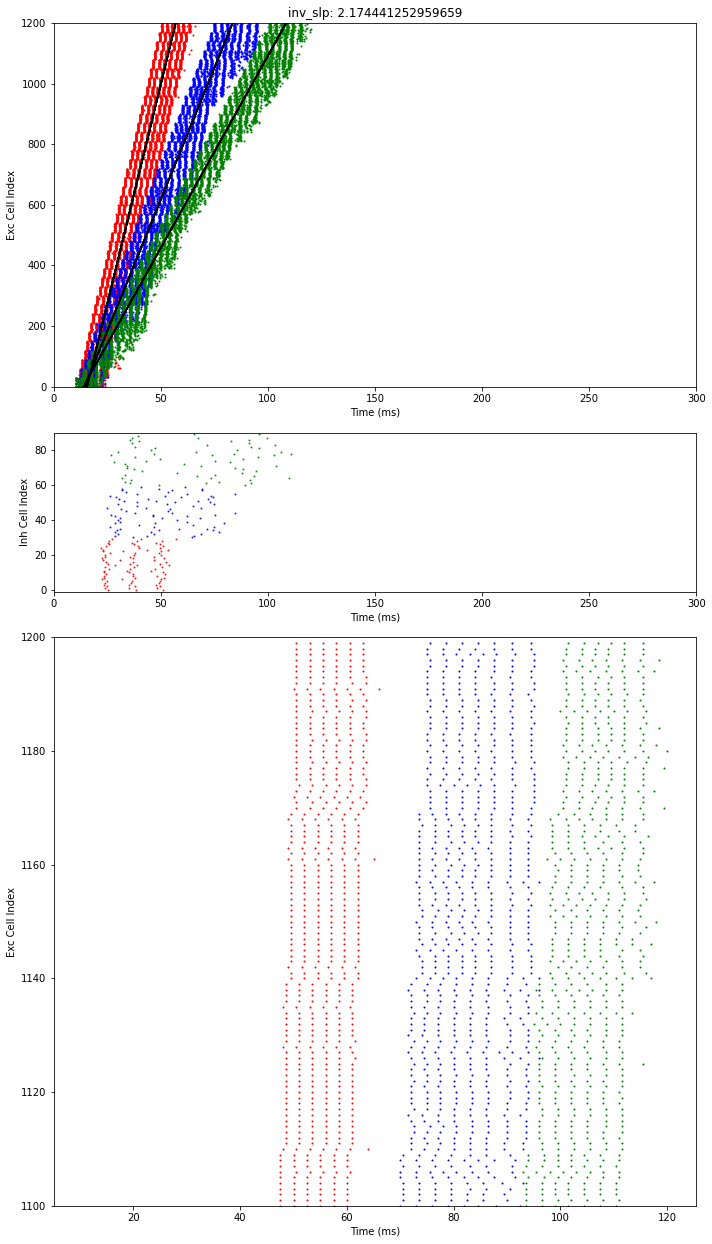

In [7]:
'''
    Parameters:
        1. excitatory -> inhibitory weight
        2. inhibitory -> excitatory weight
        3. excitatory -> excitatory recursive (within chainlink) weight
        4. excitatory -> excitatory feed-forward (chainlink -> chainlink) weight
        5. scaling factor for UVA frequency (multiply this by 0, 400, 800 Hz to get frequencies for trials)
        6. fraction of total nuerons in excitatory chainlink that a single excitatory cell receieves afferents from'
        7. fraction of total nuerons in entire chain that a single inhibitory cell receieves afferents from
'''

slps = quick_plot(m, 1.500e-06, 0, 13.0e-06, 8.5e-6, 5.5e-01, 1., 1.025e-01, 
                  overlay=True, repeats=20, show_only_first=True)
print(slps)
print(np.mean(slps))
print(np.std(slps))

### Finding parameters that permit modulation of spike pulse propagation speed via input from UVA
- a broad parameter search yeilded parameters that permited an ~80% increase in speed of propagation without use of adaptation
- I wasn't convinced these parameters led to the greatest ability to modulate speed while preserving stable propagation

[1.828509459232053, 1.8064472085539673, 1.8317057400799586, 1.635431824504306, 1.8249986149425559, 1.7952300133600143, 1.4512703951144297, 1.8392945258445292, 1.815011878767876, 1.8791189616935837, 1.8610898154463946, 1.8454378048103626, 1.8120324187328067, 1.8735101997291252, 1.895717991274049, 1.772302568528702, 1.8803423384168327, 1.8340643627415119, nan, 1.8387640956418085]
mean nan
std nan


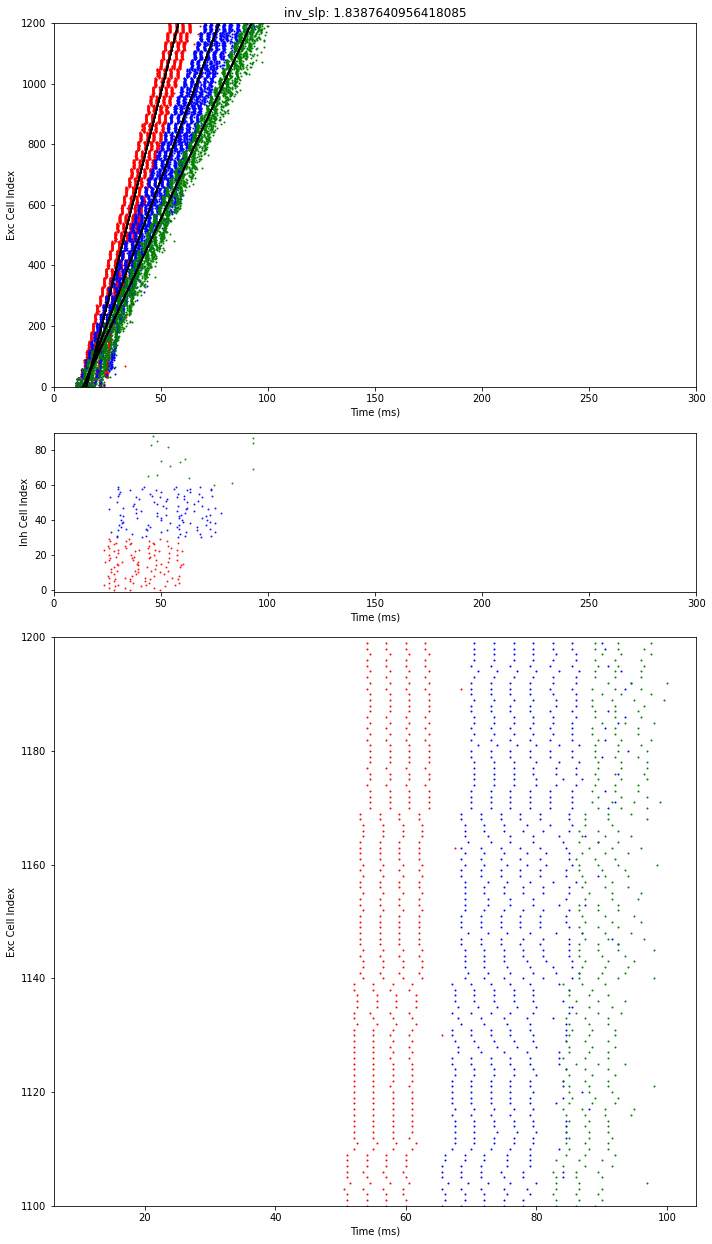

In [8]:
S.T = 0.3
m2 = copy(m)
m2.W_A = 0
set_dynamic_vars(m2)

slps = quick_plot(m2, 1.500e-06, 1.650e-06, 5.250e-06, 8.650e-06, 3.1e-01, 4.500e-01, 1.025e-01, 
                  overlay=True, repeats=20, show_only_first=True)
print(slps)
print('mean', np.mean(slps))
print('std', np.std(slps))

### Quick recap of analytical treatment from a few weeks ago
The governing equations for the conductance-based LIF network are:

1. Single neuron voltage dynamics:
$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$


2. The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.

#### Inhibitory conductance

Treat inhibitory conductance equation first. Neurons in a particular chain link receive inhibition from the inhibitory pool and UVA.
1. Assume the firing rate of UVA is constant for a particular trial. 


2. If the inhibitory pool is coupled to the chain uniformly (connections from excitatory neurons to the pool are evenly spread amongst the chainlinks), then stable dynamics in the chain imply stable dynamics in the inhibitory pool. Then, fixing all parameters, we may assume the firing rate of the inhibitory pool is constant for a particular trial.

With these assumptions, rewrite the inhibitory conductance eq.:

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \tau_i (N_{i} W_{i->e} r_{i}\ + W_{UVA} r_{UVA})$$

where $g^i_i$ is inhibitory conductance of the excitatory neuron of interest, $N_{i}$ is the number of neurons in the inhibitory pool, $W_{i->e}$ is synaptic strength of connections from the inhibitory pool to excitatory neurons, $r_{i}$ is the firing rate of a neuron in the inhibitory pool, $W_{UVA}$ is the strength of connection from UVA to excitatory neurons, and $r_{UVA}$ is the firing rate of UVA, here considered as one neuron.

The solution is falling exponential plus a constant. We ignore the transient part, and instead have steady-state $g^i_i$:

$$ g^i_i = \tau_i (N_{i} W_{i->e} r_{i}\ + W_{UVA} r_{UVA}) $$

#### Excitatory conductance

1. The first spike in a particular chainlink must be generate by spikes in the chainlink that precedes it, so we will ignore the recurrent connections within a chainlink for now.

2. If we assume a square wave of excitation received by an excitatory neuron, the solutions to the excitatory conductance equations are essentially capacitor charging and discharging equation (exponentials that decay to different constant values):

![Excitatory Conductance](./images/excitatory_conductance_graph.png)

#### Solving the voltage equation numerically and considering the basis of propagation speed modulation via input from UVA

1. Considering only the 'charging' phase of the excitatory conductance equation, we can solve the single-neuron voltage dynamics equation numerically:

![Single Neuron Voltage When Driven by Square Wave](./images/single_neuron_voltage_dynamics_graph.png)

Here is a graph illustrative of the mechanism of modulation of propagation speed. The strengths of feed-forward excitatory connections, connections from the inhibitory pool to the chainlink, and connections from UVA can be chosen such that the timing of the first spike within a chainlink is a function of the firing rate of UVA.

*Note: the weights from UVA can be chosen such that the firing rate of UVA can take arbitrary values so long as it can be considered constant.*

### Is the inhibitory pool necessary?

Imagine that the ability to module propagation speed in a stable fashion is extremized by some choice of parameters for the model discussed above. Examine again the inhibitory conductance equation:

$$ g^i_i = \tau_i (N_{i} W_{i->e} r_{i}(r_{UVA})\ + W_{UVA} r_{UVA}) $$

Here, I have rewritten $r_i$ as a function of $r_{UVA}$. In general, $r_{i}$ will depend on other parameters, but if we fix all other parameters, it will only change as a function of $r_{UVA}$.

If a choice of $r_{UVA}^{(1)}$ and $r_{UVA}^{(2)}$ leads to the maximum possible ratio of propagation speeds, a troubling thought is we could easily define:

$$ W_{UVA}^{\prime} r_{UVA}^{(1)\prime} = N_{i} W_{i->e} r_{i}(r_{UVA}^{(1)})\ + W_{UVA} r_{UVA}^{(1)} $$

$$ W_{UVA}^{\prime} r_{UVA}^{(2)\prime} = N_{i} W_{i->e} r_{i}(r_{UVA}^{(2)})\ + W_{UVA} r_{UVA}^{(2)} $$

The excitatory neuron is impartial to the source of the inhibition, so getting rid of the inhibitory pool and simply changing the input from UVA to be what is defined above would give rise to the same dynamics.

Here is some evidence we can achieve the same modulation of propagation speed without the inhibitory pool:

[1.8912439031633865, 1.878179832307528, 1.889593486885552, 1.9045593234010918, 1.8010414834630264, 1.9058498941635447, 1.8265128639145696, 1.830619163788359, 1.8262696417539093, 1.8184091081663567, 1.8810904654473102, 1.8744501968840157, 1.8982270371449836, 1.8793858302586706, 1.8468264127833618, 1.8156027330878768, 1.9143714493580963, 1.7853682150741605, 1.924366885834301, 1.8920347217032385]
mean 1.864200132429167
std 0.0403587193638912


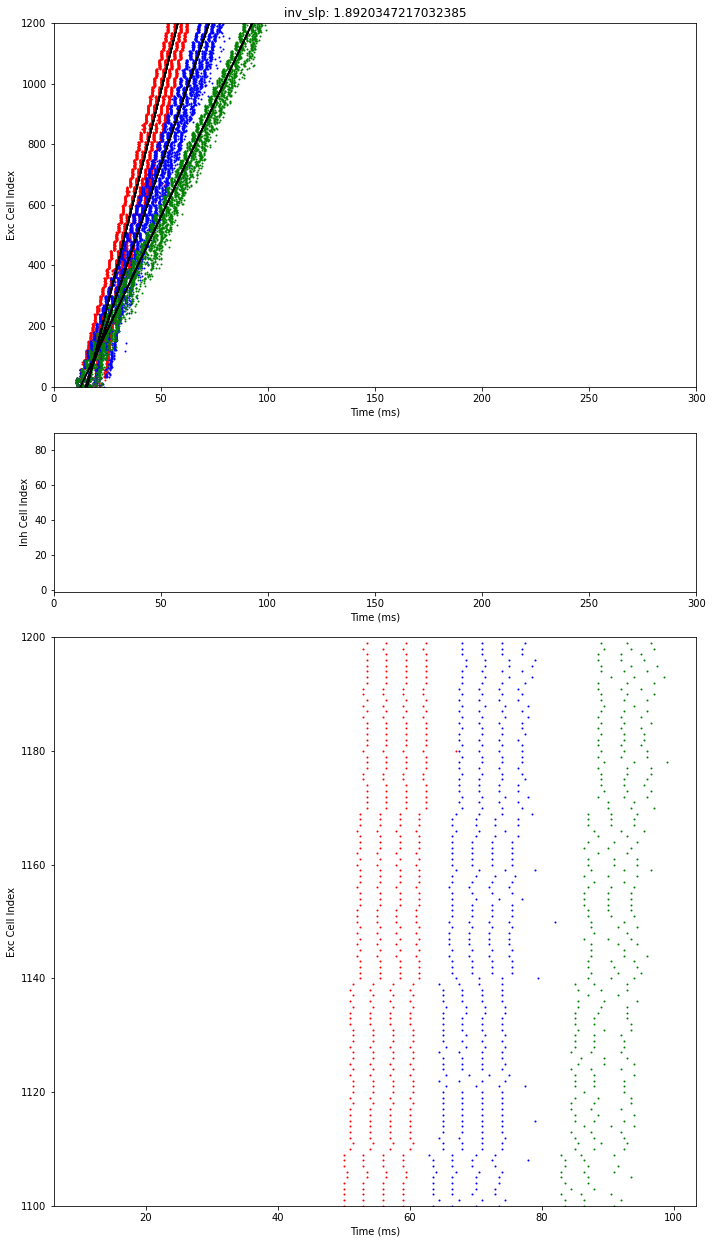

In [9]:
slps = quick_plot(m2, 0, 0, 1.8e-06, 8.0578947e-06,
 2.27777778e-01, 1.00000000e+00, 0, overlay=True, repeats=20, show_only_first=True)
print(slps)
print('mean', np.mean(slps))
print('std', np.std(slps))

### Why is an inhibitory pool present and why do its neurons exhibit dynamics that suggest they are coupled to most of the chain?

An important feature of the inhibitory pool is that it provides inhibition that is a function of the number of excitatory cells firing. If we inhibit UVA instead of the chain, then the chain will maintain robust dynamics even when excitatory cells drop out because the inhibition from the pool will be scaled by the number of cells that still fire.

I don't expect this change in architecture to change the range of possible propagation speeds, but it may make the chain dynamics robust to drop out.



[1.8911564109066386, 1.8162327073836175, 1.8861641994169434, 1.7883443362041578, 1.8220670312554799, 1.5009383537543843, 1.730215879705514, 1.92168151939801, 1.9105585228589765, 1.8947452008326509]
1.8162104161716375
0.12012752293413845


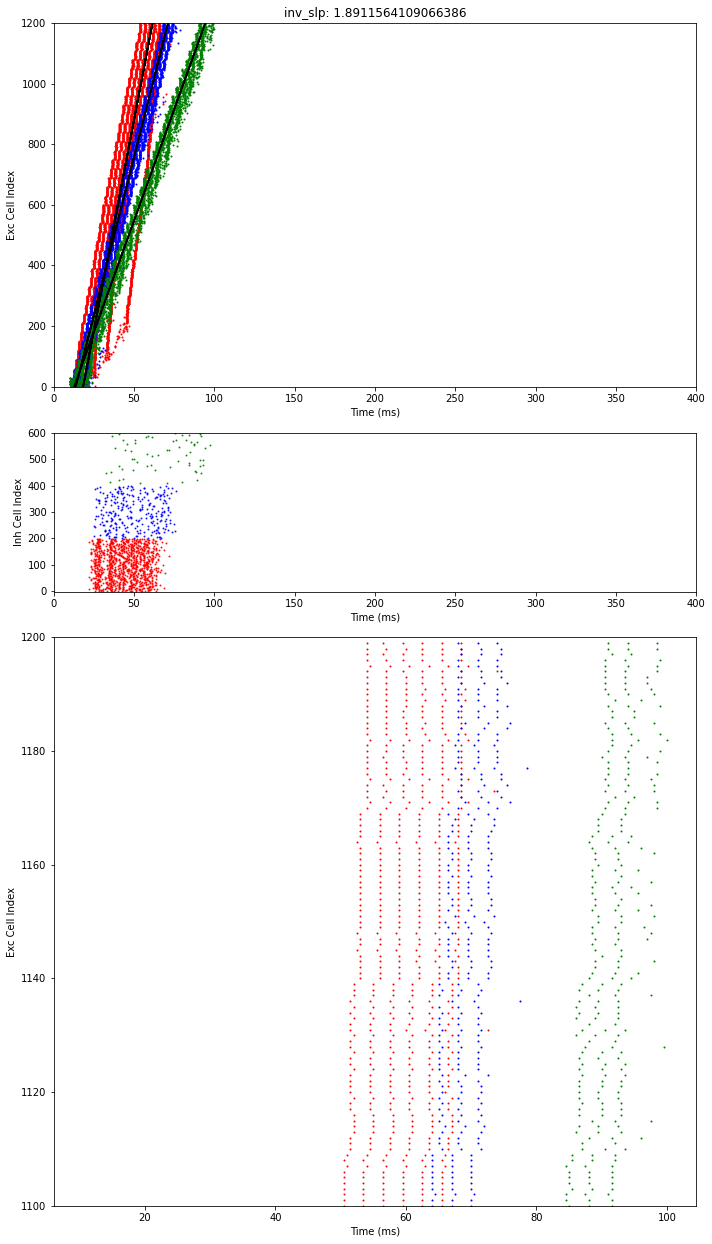

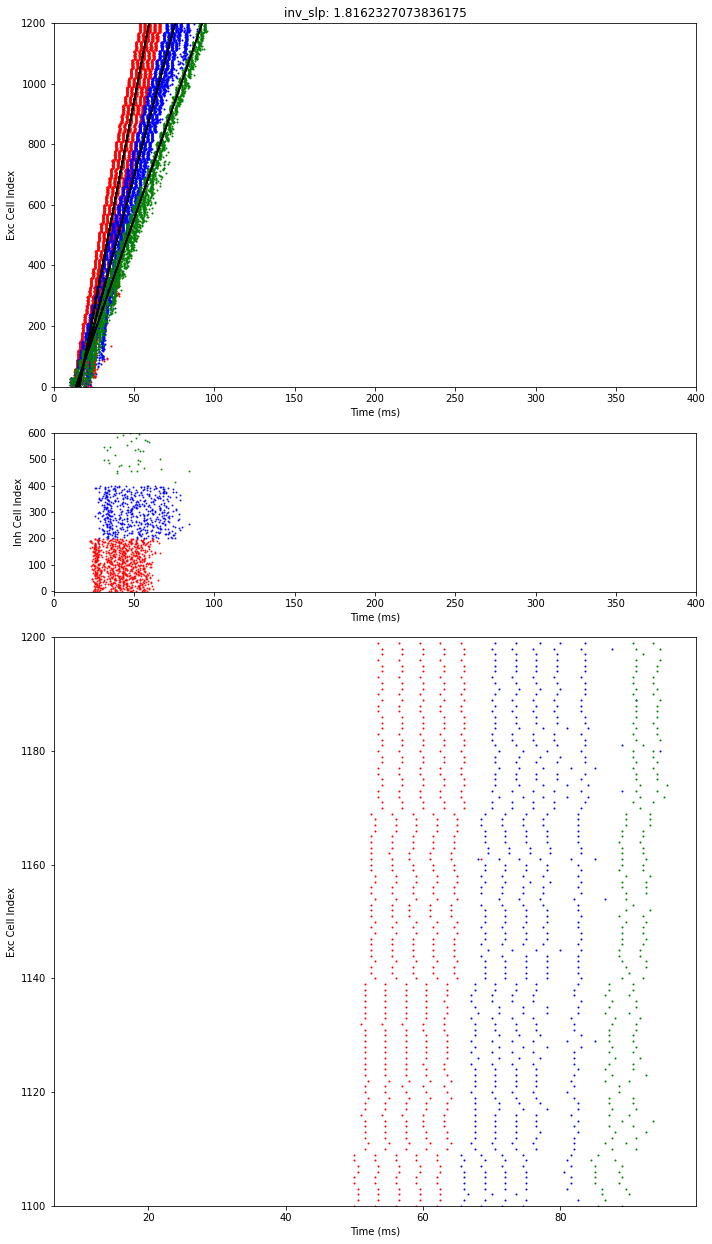

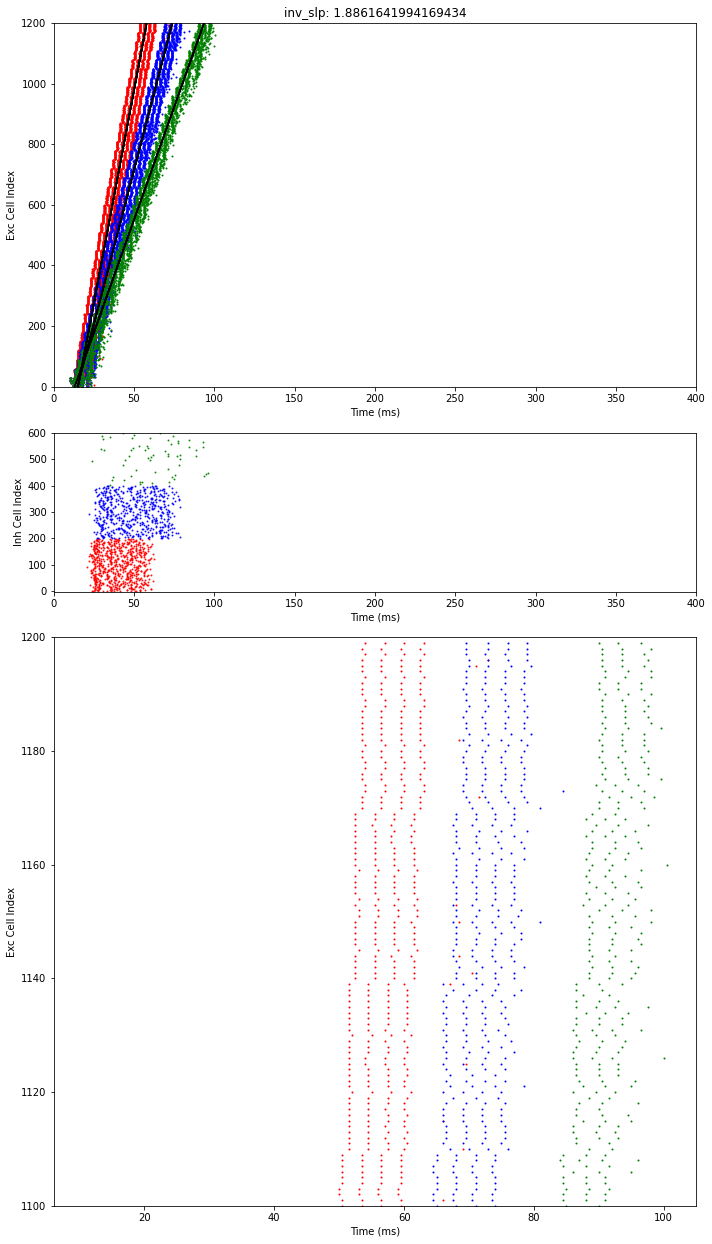

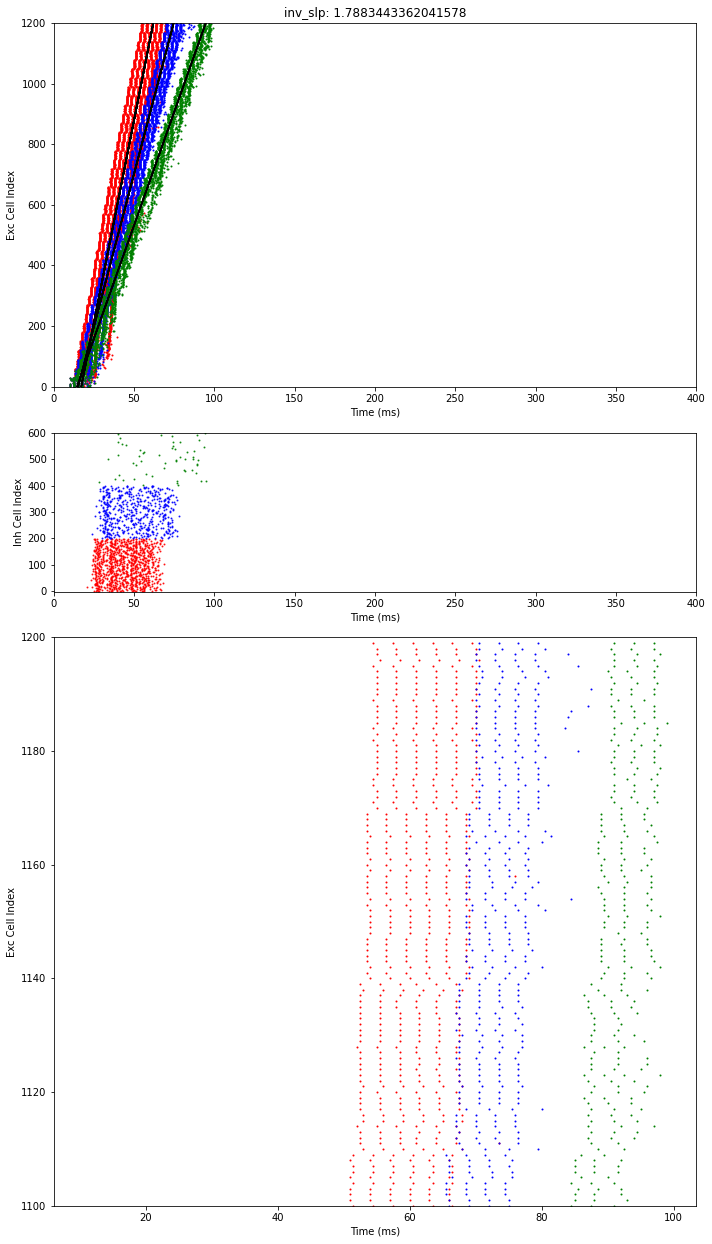

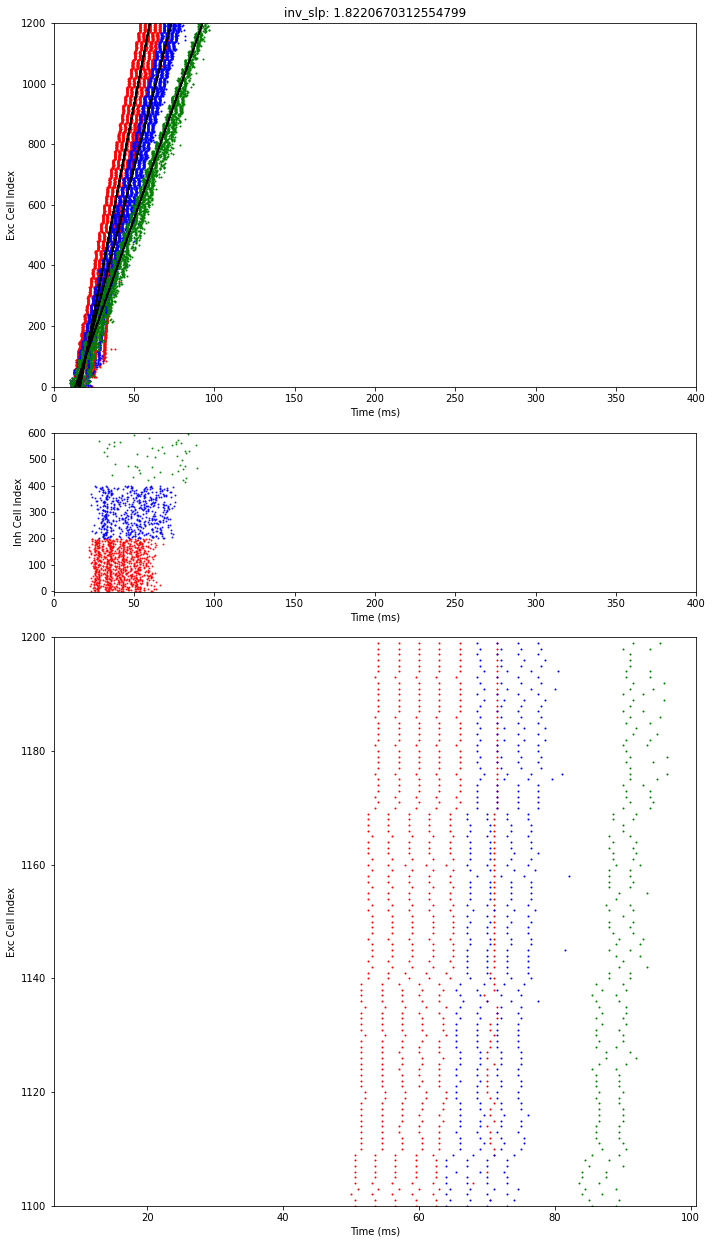

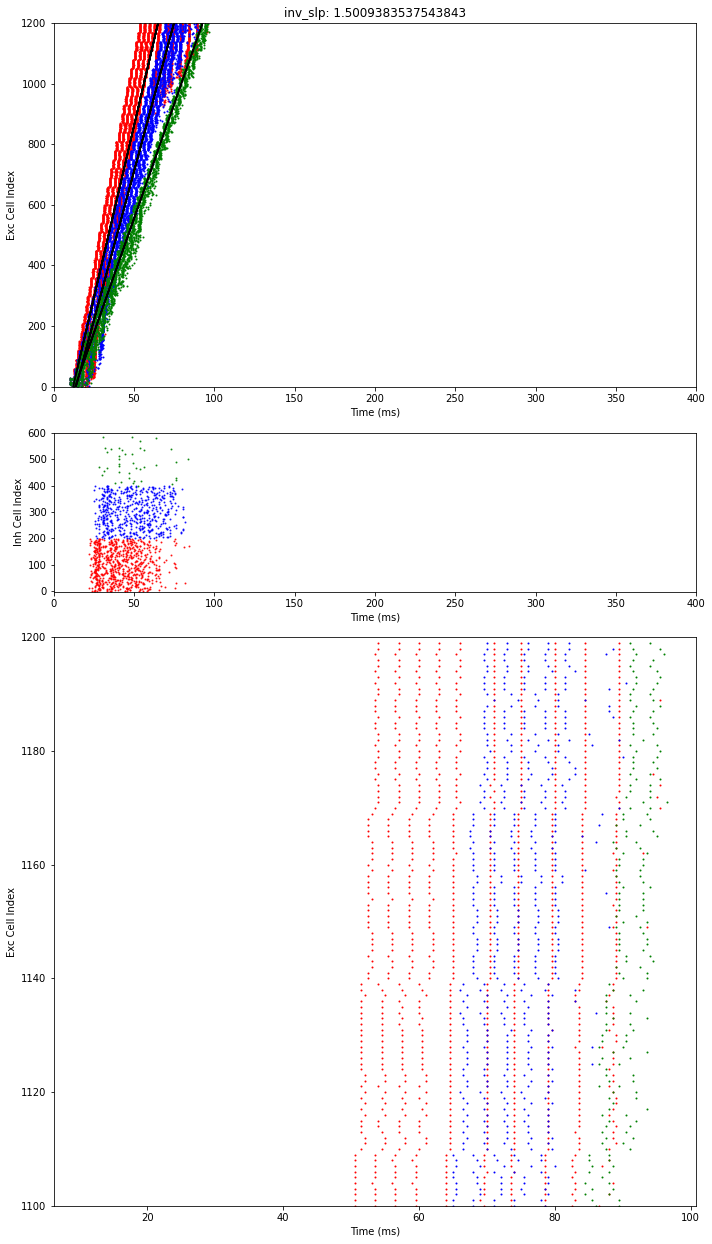

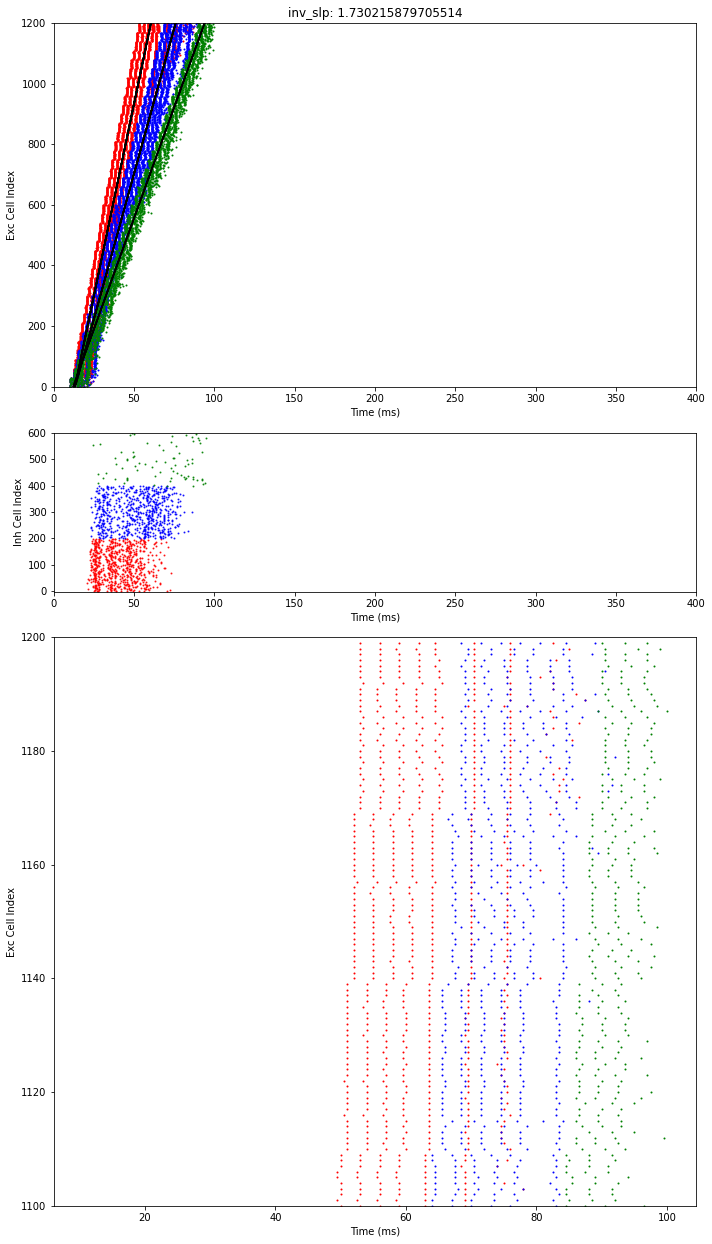

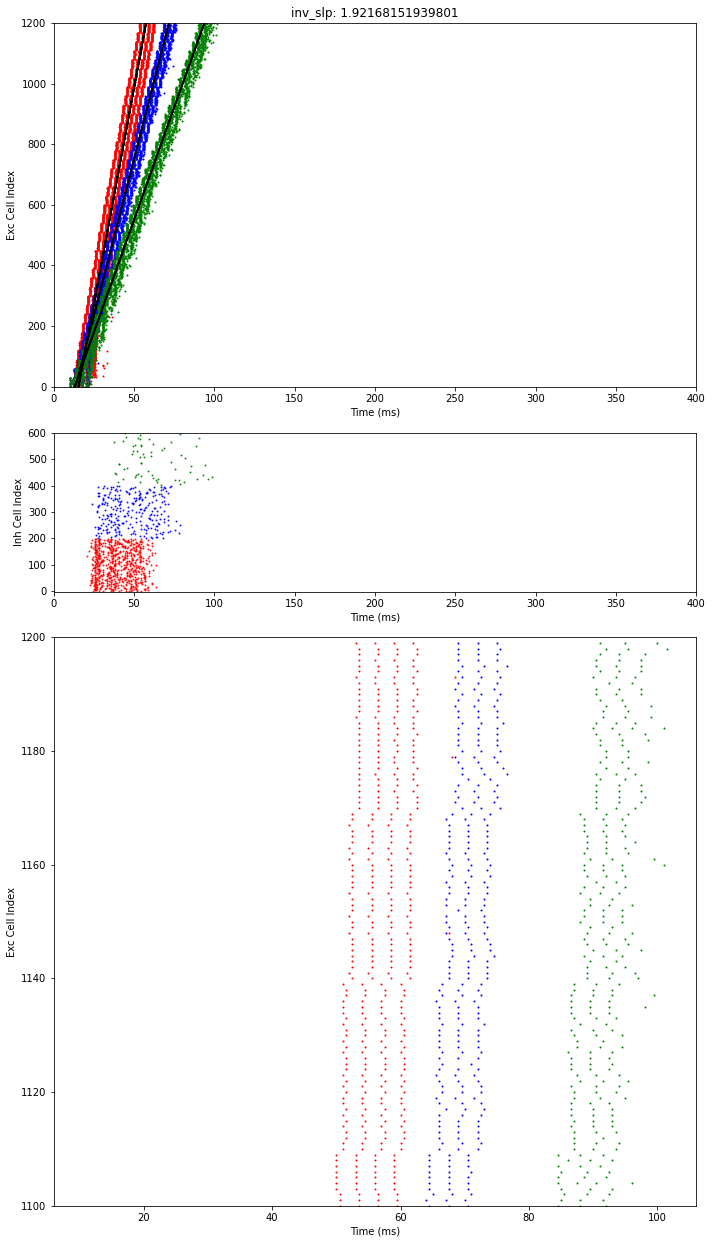

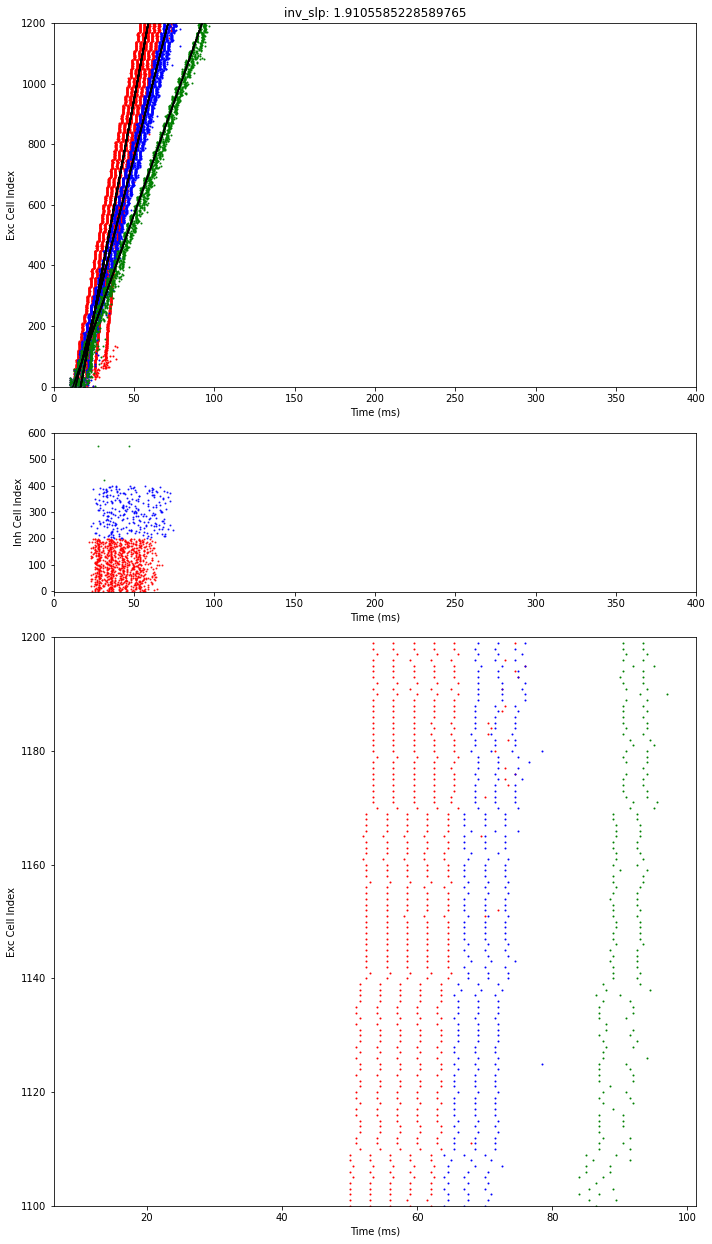

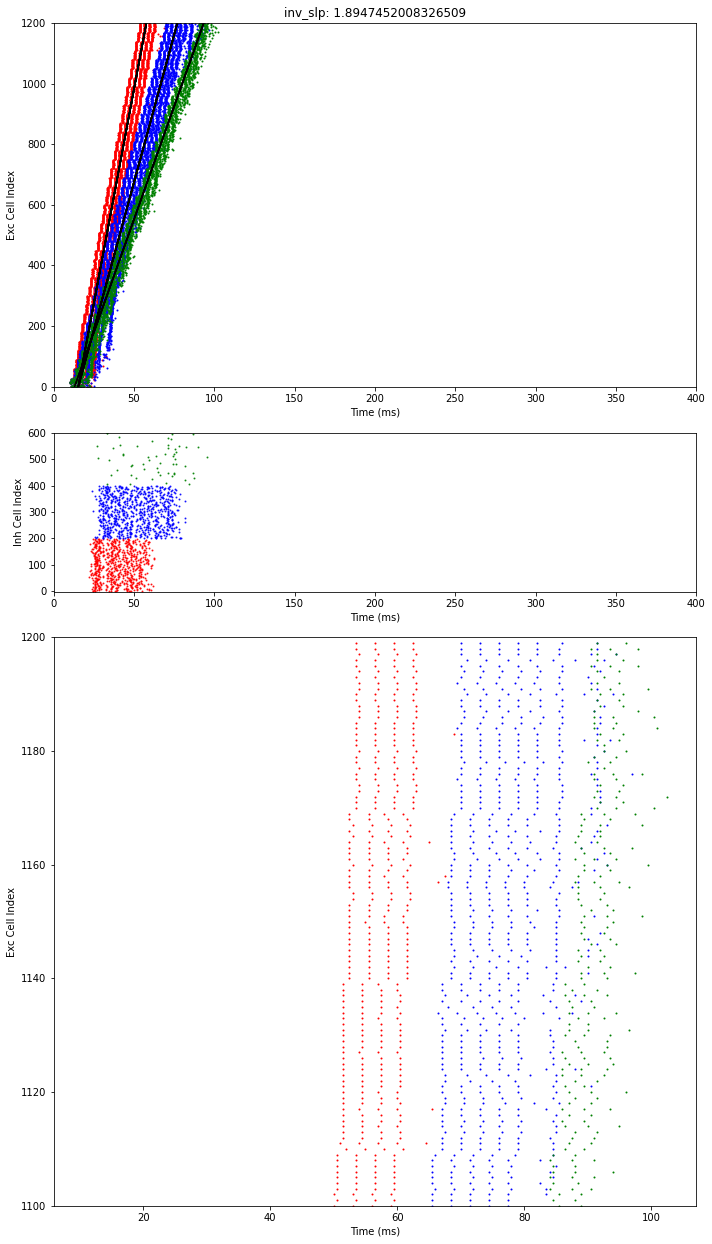

In [17]:
S.T = 0.4

m3 = copy(m)
m3.N_L = 40
m3.W_A = 0
m3.N_P_I = 200
m3.W_U_E_I = 0.1e-3

set_dynamic_vars(m3)

slps = quick_plot(m3, 1.400e-06, 1.650e-06 * 2.5/20., 5.250e-06, 8.650e-06, 3.15e-01, 4.500e-01, 1.025e-01, 
                  overlay=True, repeats=10, show_only_first=False)
print(slps)
print(np.mean(slps))
print(np.std(slps))

[1.9203130966546964,
 nan,
 1.9913358332149222,
 2.0089739724807356,
 1.953212805390464]

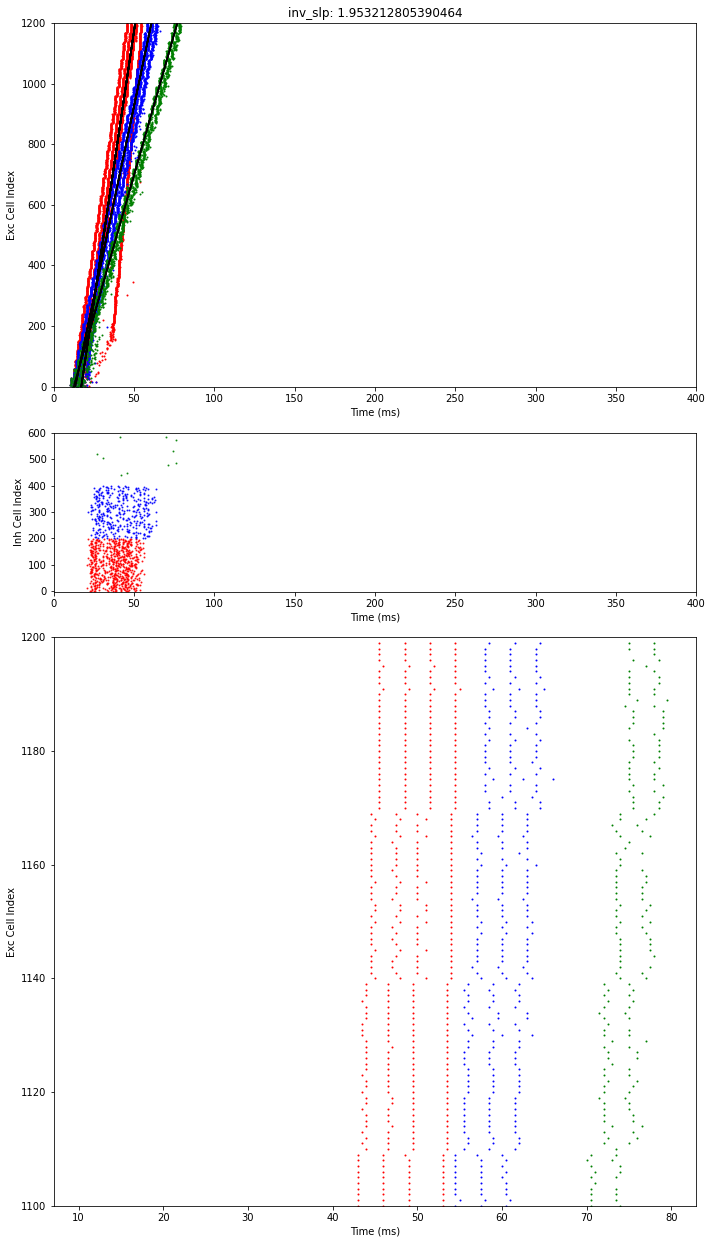

In [15]:
quick_plot(m3, 1.400e-06, 0, 0.5e-6, 10.0e-06, 3.15e-01, 4.500e-01, 1.025e-01, 
                  overlay=True, repeats=5, show_only_first=True)